## Computer vision

### Content

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Task
Identify whether the patient is suffering from pneumonia or not by looking at chest-X-ray images.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!wget --load-cookies '/content/drive/My Drive/Projects/cookies.txt' -O dataset.zip https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download
!unzip dataset.zip

In [0]:
import os 
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


In [34]:
#define seperate generator for the train,test and validation set
#the generator come with an entire suite of preprocessing steps, we used 'rescale factor 1/255.0'
#in generator we specify that the target size is (64x64)-pixels for each image and the colour mode is grayscale
#dividing by 255.0 to normalize the data which allows the classifier to converge faster.
#normalization techniques are: (divide the pixels by 255.0 'scaling') or (transform the data into a standard normal distribution to center it).
#using deep-learning (CNN) for image classification

from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)
test_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                             )

train_generator = datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/train',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='binary')

val_generator = test_datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/val',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/test',
        target_size=IMG_SIZE,
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='binary')

#The data is small in general whereby we need to use tranfer Learning (Pre-trained models). the validation-set that is used for testing is quite so small to generalize on.
# the data is small, yet it is complex to extract information using CNN, unlike mnist-data that is huge but less infromation to be extracted per image where CNN gives better performance

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
#display the image 
image_batch, label_batch = next(train_generator)
#plt.imshow(image_batch[0].reshape(64,64))
#plt.show()

In [36]:
image_batch.shape

(32, 224, 224, 1)

In [0]:
#CNN: Create Sequential model
tfkl = tf.keras.layers

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

def build_model():
    input_img = Input(shape=(224,224,1), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [40]:
model =  build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      640       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [0]:
#Binary crossentropy uses for multi-label classification, categorical crossentropy for multi-class classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
#the validatio loss should be similar to but slightly higher tham training loss
history = model.fit_generator(train_generator, epochs =30, validation_data = test_generator, steps_per_epoch=163, validation_steps=20)

Epoch 1/30
163/163 [==============================] - 99s 605ms/step - loss: 0.4062 - acc: 0.8223 - val_loss: 0.8018 - val_acc: 0.6250
Epoch 2/30
163/163 [==============================] - 94s 574ms/step - loss: 0.2482 - acc: 0.9059 - val_loss: 0.9770 - val_acc: 0.6250
Epoch 3/30
163/163 [==============================] - 93s 569ms/step - loss: 0.2221 - acc: 0.9183 - val_loss: 0.9566 - val_acc: 0.6250
Epoch 4/30
163/163 [==============================] - 93s 571ms/step - loss: 0.2023 - acc: 0.9264 - val_loss: 1.5814 - val_acc: 0.6250
Epoch 5/30
163/163 [==============================] - 93s 568ms/step - loss: 0.1876 - acc: 0.9352 - val_loss: 0.5922 - val_acc: 0.7612
Epoch 6/30
163/163 [==============================] - 93s 568ms/step - loss: 0.1816 - acc: 0.9367 - val_loss: 0.3992 - val_acc: 0.8061
Epoch 7/30
163/163 [==============================] - 92s 566ms/step - loss: 0.1597 - acc: 0.9402 - val_loss: 1.1383 - val_acc: 0.7115
Epoch 8/30
163/163 [==============================] - 9

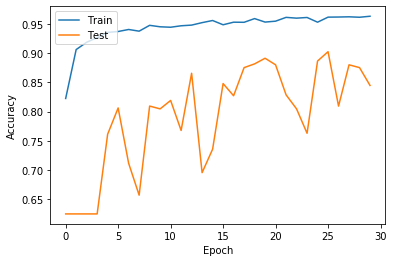

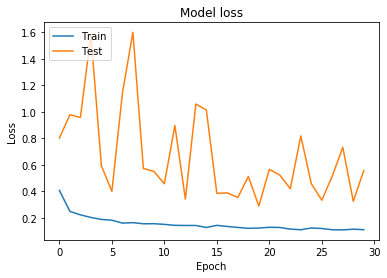

In [43]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
